In [28]:
:opt no-lint
import Diagrams.Backend.Cairo.CmdLine

This is a reconstruction of [M C Escher's print "Square
Limit"](http://www.wikipaintings.org/en/m-c-escher/square-limit). It
is based on the classic paper "Functional Geometry" by Peter Henderson
(in Lisp and Functional Programming, 1982). But we take a slightly
different approach: using lazy evaluation, we construct an infinite
diagram, then prune it to some finite depth before writing out as
SVG---Henderson's code hardwired an unrolling to a particular depth.



In [2]:
{-# LANGUAGE NoMonomorphismRestriction TypeFamilies FlexibleContexts #-}

import Prelude hiding (cycle)
import Diagrams.Prelude

The type signatures are more specific than necessary, but perhaps
easier to understand this way.

The diagram is constructed from five basic tiles: four with specific
markings on, and a fifth which is blank, all $16 \times 16$. The actual
markings are defined at the end of the file.



In [3]:
blank :: Diagram B
blank = lw none $ square 16

In [4]:
makeTile :: [[P2 Double]] -> Diagram B
makeTile = showOrigin . lw thin . centerXY . mconcat . map fromVertices

Here is an algenraic datatype of pictures. Composition is by
juxtaposition, which requires bounding boxes. In order to achieve this
even with infinite pictures, we make all pictures the same size
($16 \times 16$), by scaling.



In [6]:
data Picture
  = Blank
  | Single [[P2 Double]]
  | Rot Picture
  | Cycle Picture
  | HPair Picture Picture
  | VPair Picture Picture
  | Quartet Picture Picture Picture Picture
  | SkewQuartet Picture Picture Picture Picture -- left column and bottom row half size

`Blank` and `Single` correspond to the basic tiles. `Rot` rotates by $90$
degrees, anticlockwise. `Cycle` puts together four half-size copies of a
picture: unrotated at top right, and each one anticlockwise from there
rotated by a further quarter turn. `HPair` puts two pictures side by
side, and `VPair` one above another; each picture is scaled by a half in
one dimension. `Quartet` puts together four pictures at half
size. `SkewQuartet` does similarly, but in a $2:1$ size ratio: the left
column is half the width and the bottom row half the right of the
right column and the top row. These maintain the invariant at all
pictures are the same size.



In [7]:
rot p = rotateBy (1/4) p
cycle p = quartet (rot p) p (rot $ rot p) (rot $ rot $ rot p)
hpair p q = scaleX (1/2) $ centerXY (p ||| q)
vpair p q = scaleY (1/2) $ centerXY (p === q)
quartet p q r s = scale (1/2) $ centerXY ((p ||| q) === (r ||| s))
skewquartet p q r s = scale (1/3) $ centerXY ((scaleY 2 p ||| scale 2 q)
                                              === (r ||| scaleX 2 s))

Line 1: Eta reduce
Found:
rot p = rotateBy (1 / 4) p
Why not:
rot = rotateBy (1 / 4)

Folding with these operators draws a whole picture.



In [8]:
drawPicture :: Picture -> Diagram B
drawPicture Blank = blank
drawPicture (Single m) = makeTile m
drawPicture (Rot p) = rot (drawPicture p)
drawPicture (Cycle p) = cycle (drawPicture p)
drawPicture (HPair p q) = hpair (drawPicture p) (drawPicture q)
drawPicture (VPair p q) = vpair (drawPicture p) (drawPicture q)
drawPicture (Quartet p q r s)
  = quartet (drawPicture p) (drawPicture q) (drawPicture r) (drawPicture s)
drawPicture (SkewQuartet p q r s)
  = skewquartet (drawPicture p) (drawPicture q) (drawPicture r) (drawPicture s)


Pruning with `prune s p` cuts off a picture `p` when its scale gets
below $1/s$. We keep track of the scale in $x$ and $y$ separately, to cope
with the non-homogeneous scaling in `HPair` and `VPair`. The definition
only works properly if `Cycles` are scaled only homogenously; that is
the case in Escher's picture.



In [9]:
prune :: Double -> Picture -> Picture
prune s p = prune' (s,s) p where
  prune' (x,y) p | min x y < 1 = Blank -- cut off when either factor <1
  prune' (x,y) Blank = Blank
  prune' (x,y) (Single m) = Single m
  prune' (x,y) (Rot p) = Rot (prune' (y,x) p)
  prune' (x,y) (Cycle p) = Cycle (prune' (x/2,y/2) p) -- assumes x==y
  prune' (x,y) (HPair p q) = HPair (prune' (x/2,y) p) (prune' (x/2,y) q)
  prune' (x,y) (VPair p q) = VPair (prune' (x,y/2) p) (prune' (x,y/2) q)
  prune' (x,y) (Quartet p q r s)
    = Quartet (prune' x2y2 p) (prune' x2y2 q) (prune' x2y2 r) (prune' x2y2 s)
      where x2y2 = (x/2,y/2)
  prune' (x,y) (SkewQuartet p q r s)
    = SkewQuartet (prune' (x3,y32) p) (prune' (x32,y32) q)
                  (prune' (x3,y3) r) (prune' (x32,y3) s)
      where (x3,y3,x32,y32) = (x/3,y/3,x3*2,y3*2)

Now for the construction of Escher's Square Limit. The four basic
tiles are as follows:



In [23]:
fishP = Single markingsP
fishQ = Single markingsQ
fishR = Single markingsR
fishS = Single markingsS

Henderson puts them together in a quartet, and cycles this:



In [24]:
fishT = Quartet fishP fishQ fishR fishS
fishU = Cycle (Rot fishQ)

This is the recursive structure of one corner of Square Limit:



In [25]:
corner = SkewQuartet p q r s where
  p = VPair p' fishT
  p' = HPair (Rot s) p
  q = Quartet p' q fishU s'
  r = fishQ
  s = HPair fishT s'
  s' = VPair s (Rot (Rot (Rot p)))

The final picture is a cycle of these corners.



In [26]:
squarelimit = Cycle corner

example = drawPicture (prune 24 squarelimit) `atop` square 14.5
        # fc darkseagreen
        # opacity 0.5

The markings on the four basic tiles are taken from [a note by Frank
Buss](http://www.frank-buss.de/lisp/functional.html).



In [29]:
markingsP = [
  [ (4^&4), (6^&0) ],
  [ (0^&3), (3^&4), (0^&8), (0^&3) ],
  [ (4^&5), (7^&6), (4^&10), (4^&5) ],
  [ (11^&0), (10^&4), (8^&8), (4^&13), (0^&16) ],
  [ (11^&0), (14^&2), (16^&2) ],
  [ (10^&4), (13^&5), (16^&4) ],
  [ (9^&6), (12^&7), (16^&6) ],
  [ (8^&8), (12^&9), (16^&8) ],
  [ (8^&12), (16^&10) ],
  [ (0^&16), (6^&15), (8^&16), (12^&12), (16^&12) ],
  [ (10^&16), (12^&14), (16^&13) ],
  [ (12^&16), (13^&15), (16^&14) ],
  [ (14^&16), (16^&15) ]
  ]


In [30]:
markingsQ = [
  [ (2^&0), (4^&5), (4^&7) ],
  [ (4^&0), (6^&5), (6^&7) ],
  [ (6^&0), (8^&5), (8^&8) ],
  [ (8^&0), (10^&6), (10^&9) ],
  [ (10^&0), (14^&11) ],
  [ (12^&0), (13^&4), (16^&8), (15^&10), (16^&16), (12^&10), (6^&7), (4^&7), (0^&8) ],
  [ (13^&0), (16^&6) ],
  [ (14^&0), (16^&4) ],
  [ (15^&0), (16^&2) ],
  [ (0^&10), (7^&11) ],
  [ (9^&12), (10^&10), (12^&12), (9^&12) ],
  [ (8^&15), (9^&13), (11^&15), (8^&15) ],
  [ (0^&12), (3^&13), (7^&15), (8^&16) ],
  [ (2^&16), (3^&13) ],
  [ (4^&16), (5^&14) ],
  [ (6^&16), (7^&15) ]
  ]


In [31]:
markingsR = [
  [ (0^&12), (1^&14) ],
  [ (0^&8), (2^&12) ],
  [ (0^&4), (5^&10) ],
  [ (0^&0), (8^&8) ],
  [ (1^&1), (4^&0) ],
  [ (2^&2), (8^&0) ],
  [ (3^&3), (8^&2), (12^&0) ],
  [ (5^&5), (12^&3), (16^&0) ],
  [ (0^&16), (2^&12), (8^&8), (14^&6), (16^&4) ],
  [ (6^&16), (11^&10), (16^&6) ],
  [ (11^&16), (12^&12), (16^&8) ],
  [ (12^&12), (16^&16) ],
  [ (13^&13), (16^&10) ],
  [ (14^&14), (16^&12) ],
  [ (15^&15), (16^&14) ]
  ]


In [32]:
markingsS = [
  [ (0^&0), (4^&2), (8^&2), (16^&0) ],
  [ (0^&4), (2^&1) ],
  [ (0^&6), (7^&4) ],
  [ (0^&8), (8^&6) ],
  [ (0^&10), (7^&8) ],
  [ (0^&12), (7^&10) ],
  [ (0^&14), (7^&13) ],
  [ (8^&16), (7^&13), (7^&8), (8^&6), (10^&4), (16^&0) ],
  [ (10^&16), (11^&10) ],
  [ (10^&6), (12^&4), (12^&7), (10^&6) ],
  [ (13^&7), (15^&5), (15^&8), (13^&7) ],
  [ (12^&16), (13^&13), (15^&9), (16^&8) ],
  [ (13^&13), (16^&14) ],
  [ (14^&11), (16^&12) ],
  [ (15^&9), (16^&10) ]
  ]


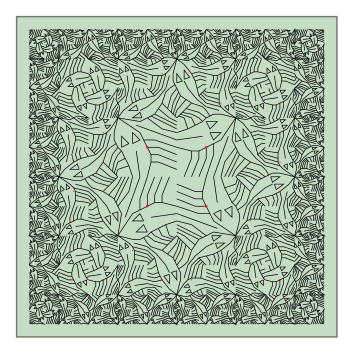

In [33]:
diagram example